# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [4]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Index([118664], dtype='int64')
136244


Same problem for B-set at `2022-05-02 23:00:00` and C-set at `2022-04-25 21:00:00`

In [5]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

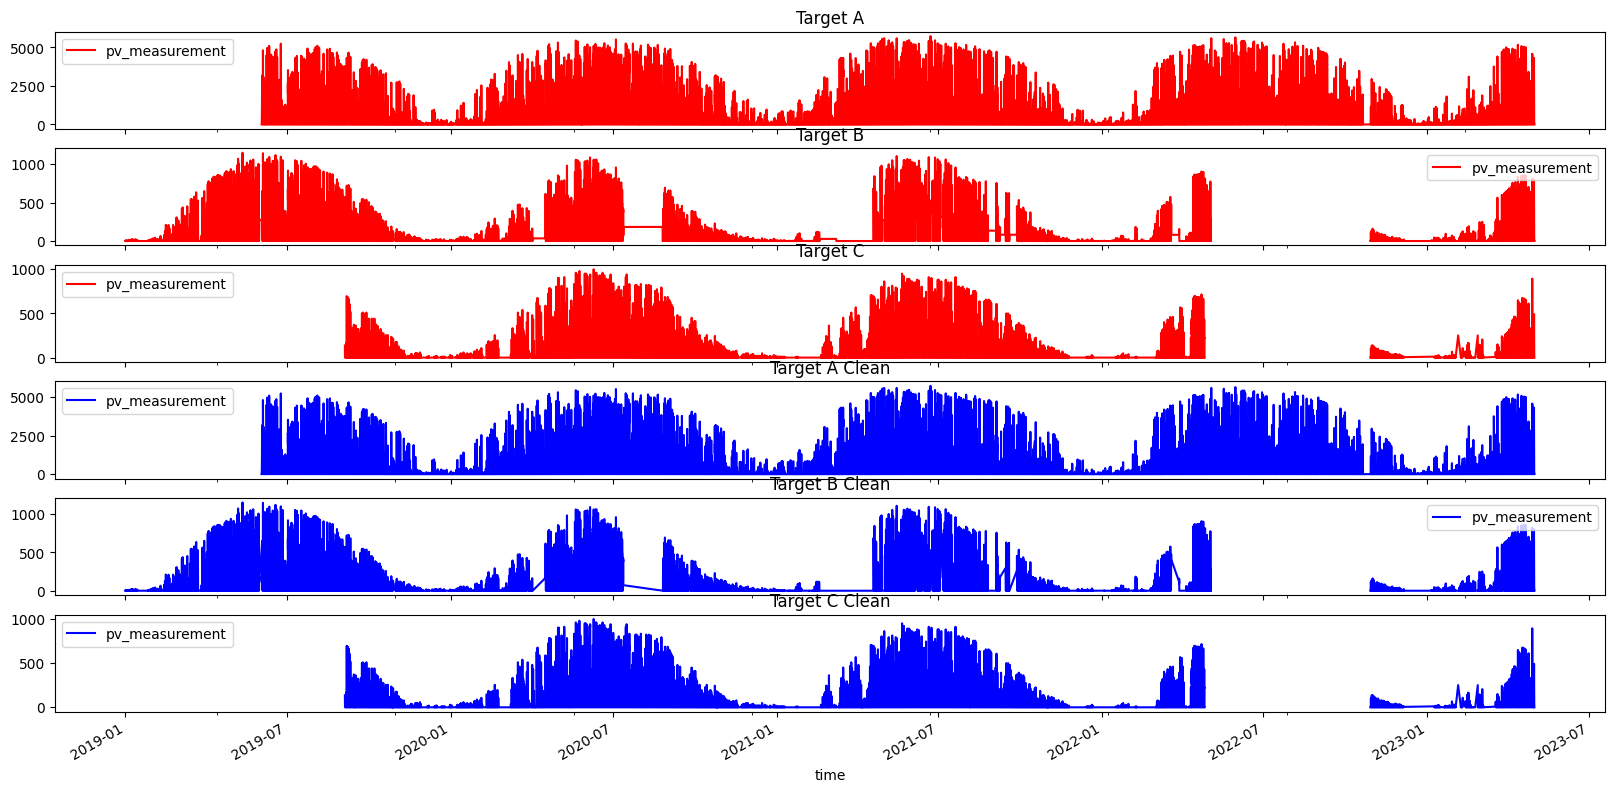

In [6]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [7]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [9]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34055   2023-04-30 19:00:00
34056   2023-04-30 20:00:00
34057   2023-04-30 21:00:00
34058   2023-04-30 22:00:00
34059   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]


# Feature engineering

In [10]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


In [11]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_energy_1h:J']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_energy_1h:J']

    X_train[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] =  multiply_columns(AT, BT)

## Data Cleaning

In [12]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199
snow_density:kgm3,32920,28040,24561


In [13]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [14]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

In [15]:
drop_cols_a = [
    #"fresh_snow_12h:cm", 
    #"fresh_snow_1h:cm",
    #"fresh_snow_24h:cm",
    #"fresh_snow_3h:cm",
    #"fresh_snow_6h:cm",
    #"snow_drift:idx",
    #"snow_depth:cm",
    #"snow_melt_10min:mm",
    #"snow_water:kgm2"
]

#X_train[0].drop(columns=drop_cols_a, inplace=True)
#X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

In [16]:
from data_func.combine_all_frames import combine_all_frames
B=X_train[1].__deepcopy__()
C=X_train[2].__deepcopy__()
X_train_BC = combine_all_frames([B, C])
YB = Y_train[1].__deepcopy__()
YC = Y_train[2].__deepcopy__()
Y_train_BC = pd.concat([YB, YC])
Y_train_BC.reset_index(drop=True)
X_frames_test = combine_all_frames([X_frames_test[1], X_frames_test[2]])

# Training the model

In [17]:
import tensorflow as tf
import autokeras as ak

Using TensorFlow backend


In [18]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)
x_train_bc, x_val_bc, y_train_bc, y_val_bc = train_test_split(X_train_BC, Y_train_BC, test_size=0.17, random_state=42)

In [19]:
normalizer_A = tf.keras.layers.Normalization(axis=-1)
normalizer_A.adapt(X_train[0])

first = np.array(X_train[0][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_A(first).numpy())

normalizer_B = tf.keras.layers.Normalization(axis=-1)
normalizer_B.adapt(X_train[1])
normalizer_C = tf.keras.layers.Normalization(axis=-1)
normalizer_C.adapt(X_train[2])
normalizer_BC = tf.keras.layers.Normalization(axis=-1)
normalizer_BC.adapt(X_train_BC)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

First example: [[    0.       1.       7.7      1.23  1728.95     0.       0.    1728.95
    280.3      0.       0.       0.       0.      99.07     0.       0.
      0.       0.       0.    1006.3      0.     993.75   999.78     0.
      0.      71.67  1005.8      0.       0.       0.       0.17   348.04
     -3.77     0.     286.23   100.   40386.48     3.6     -3.57    -0.5
      0.      -0.5      0.87     0.49    -0.87     0.       1.       0.
      1.       0.       0.       0.       0.       0.  ]]

Normalized: [[-0.97  0.95  0.49 -0.67 -0.62 -0.65 -0.65 -0.26  0.63 -0.67 -0.68 -0.46
  -0.46  0.93 -0.15 -0.09 -0.19 -0.1  -0.12 -0.26 -0.2  -0.23 -0.24 -0.08
  -0.25 -0.17 -0.25 -0.16  0.   -0.05  0.36  1.72 -0.15 -0.54  0.94  0.77
   0.44  0.3  -1.46 -0.58 -0.01 -0.71  1.22  0.71 -1.25 -0.09  0.19 -0.17
   0.24 -0.21 -0.07 -0.08 -0.01 -0.42]]


In [20]:
model_a = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=54),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_A, 
    tf.keras.layers.Dense(1024, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss="mse", 
                metrics=["mae", "mse"])

history_a = model_a.fit(x=x_train_a, y=y_train_a, epochs=1000, callbacks=[early_stop], validation_split=0.2)

Epoch 1/1000
707/707 [==============================] - 1s 2ms/step - loss: 543091.2500 - mae: 335.6893 - mse: 543091.2500 - val_loss: 228199.1875 - val_mae: 234.2713 - val_mse: 228199.1875
Epoch 2/1000
707/707 [==============================] - 1s 1ms/step - loss: 313252.4375 - mae: 266.3782 - mse: 313252.4375 - val_loss: 217488.1406 - val_mae: 223.4828 - val_mse: 217488.1406
Epoch 3/1000
707/707 [==============================] - 1s 1ms/step - loss: 316214.1562 - mae: 264.6230 - mse: 316214.1562 - val_loss: 216796.5312 - val_mae: 220.9109 - val_mse: 216796.5312
Epoch 4/1000
707/707 [==============================] - 1s 1ms/step - loss: 302704.0000 - mae: 259.8214 - mse: 302704.0000 - val_loss: 225230.1719 - val_mae: 225.1677 - val_mse: 225230.1719
Epoch 5/1000
707/707 [==============================] - 1s 1ms/step - loss: 297787.3438 - mae: 259.0414 - mse: 297787.3438 - val_loss: 215727.0938 - val_mae: 220.4341 - val_mse: 215727.0938
Epoch 6/1000
707/707 [============================

In [21]:
a = tf.keras.models.load_model("./tensorflow_models/best_a_01_11.keras")
a.get_config()
a.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 53)]              0         
                                                                 
 multi_category_encoding (M  (None, 53)                0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 53)                107       
 on)                                                             
                                                                 
 dense (Dense)               (None, 1024)              55296     
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [22]:
print(model_a.evaluate(x_val_a, y_val_a))
print(a.evaluate(x_val_a, y_val_a))

181/181 [==============================] - 0s 504us/step - loss: 138797.0312 - mae: 194.6623 - mse: 138797.0312
[138797.03125, 194.6622772216797, 138797.03125]


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2042, in test_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2025, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2013, in run_step  **
        outputs = model.test_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1893, in test_step
        y_pred = self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 53), found shape=(None, 54)


In [ ]:
b = tf.keras.models.load_model("./tensorflow_models/best_b_01_11.keras")
b.get_config()
#b.summary()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 53),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'autokeras.keras_layers',
   'class_name': 'MultiCategoryEncoding',
   'config': {'name': 'multi_category_encoding',
    'trainable': True,
    'dtype': 'float32',
    'encoding': ['int',
     'int',
     'int',
     'int',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'int',
     'none',
     'int',
     'none',
     'none',
     'int',
     'int',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'none',
     'none',
     'int',
     'none',
     'none',
     'none',
     'int',
     'int',
   

In [23]:
model_b = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=54),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_B, 
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1)
])

model_b.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), 
                loss="mse", 
                metrics=["mae", "mse"])

history_b = model_b.fit(x=x_train_b, y=y_train_b, epochs=1000, callbacks=[early_stop], validation_split=0.2)

Epoch 1/1000
615/615 [==============================] - 1s 856us/step - loss: 10784.1299 - mae: 42.7548 - mse: 10784.1299 - val_loss: 5326.5811 - val_mae: 31.7971 - val_mse: 5326.5811
Epoch 2/1000
615/615 [==============================] - 0s 770us/step - loss: 5561.2759 - mae: 31.9690 - mse: 5561.2759 - val_loss: 5188.5996 - val_mae: 31.1913 - val_mse: 5188.5996
Epoch 3/1000
615/615 [==============================] - 0s 707us/step - loss: 5415.5459 - mae: 31.3328 - mse: 5415.5459 - val_loss: 5279.7803 - val_mae: 31.4478 - val_mse: 5279.7803
Epoch 4/1000
615/615 [==============================] - 0s 708us/step - loss: 5310.7026 - mae: 30.6929 - mse: 5310.7026 - val_loss: 4984.0649 - val_mae: 30.3500 - val_mse: 4984.0649
Epoch 5/1000
615/615 [==============================] - 0s 661us/step - loss: 5181.3271 - mae: 30.1725 - mse: 5181.3271 - val_loss: 4955.7109 - val_mae: 29.7903 - val_mse: 4955.7109
Epoch 6/1000
615/615 [==============================] - 0s 658us/step - loss: 5131.5625 

In [24]:
model_b.evaluate(x_val_b, y_val_b)

158/158 [==============================] - 0s 438us/step - loss: 80426.7734 - mae: 31.7840 - mse: 80426.7734


[80426.7734375, 31.78400993347168, 80426.7734375]

In [ ]:
c = tf.keras.models.load_model("./tensorflow_models/best_c_01_11.keras")
c.summary()
c.get_config()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 53)]              0         
                                                                 
 multi_category_encoding (M  (None, 53)                0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 53)                107       
 on)                                                             
                                                                 
 dense (Dense)               (None, 32)                1728      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0     

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 53),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'autokeras.keras_layers',
   'class_name': 'MultiCategoryEncoding',
   'config': {'name': 'multi_category_encoding',
    'trainable': True,
    'dtype': 'float32',
    'encoding': ['int',
     'int',
     'int',
     'int',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'int',
     'none',
     'int',
     'none',
     'none',
     'none',
     'int',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'none',
     'none',
     'int',
     'none',
     'none',
     'none',
     'int',
     'int',
  

In [29]:
model_c = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=54),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_C, 
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

model_c.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                loss="mae", 
                metrics=["mae", "mse", 'accuracy'])

history_c = model_c.fit(x=x_train_c, y=y_train_c, epochs=1000, callbacks=[early_stop], validation_split=0.2)

Epoch 1/1000
541/541 [==============================] - 1s 783us/step - loss: 53.5021 - mae: 53.5021 - mse: 17938.8262 - accuracy: 0.4644 - val_loss: 28.2628 - val_mae: 28.2628 - val_mse: 4447.3589 - val_accuracy: 0.5707
Epoch 2/1000
541/541 [==============================] - 0s 630us/step - loss: 32.1141 - mae: 32.1141 - mse: 5978.6694 - accuracy: 0.5685 - val_loss: 26.0969 - val_mae: 26.0969 - val_mse: 3887.9514 - val_accuracy: 0.5862
Epoch 3/1000
541/541 [==============================] - 0s 676us/step - loss: 30.7472 - mae: 30.7472 - mse: 5661.0063 - accuracy: 0.5700 - val_loss: 25.3670 - val_mae: 25.3670 - val_mse: 3710.9844 - val_accuracy: 0.5816
Epoch 4/1000
541/541 [==============================] - 0s 593us/step - loss: 30.1166 - mae: 30.1166 - mse: 5368.5405 - accuracy: 0.5665 - val_loss: 23.9237 - val_mae: 23.9237 - val_mse: 3349.1174 - val_accuracy: 0.5848
Epoch 5/1000
541/541 [==============================] - 0s 595us/step - loss: 29.4620 - mae: 29.4620 - mse: 5244.2485 -

In [30]:
model_c.evaluate(x_val_c, y_val_c)

139/139 [==============================] - 0s 462us/step - loss: 20.9895 - mae: 20.9895 - mse: 2860.6399 - accuracy: 0.5944


[20.989486694335938, 20.989486694335938, 2860.639892578125, 0.594350278377533]

Seems like `C` and `B` can utilize same model

In [27]:
model_bc = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=55),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_BC, 
    tf.keras.layers.Dense(1024, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_bc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss="mse", 
                metrics=["mae", "mse", 'accuracy'])

history_bc = model_bc.fit(x=x_train_bc, y=y_train_bc, epochs=1000, callbacks=[early_stop], validation_split=0.2)

Epoch 1/1000
1155/1155 [==============================] - 2s 2ms/step - loss: 8577.5303 - mae: 38.2884 - mse: 8577.5303 - accuracy: 0.4473 - val_loss: 4700.8291 - val_mae: 29.5693 - val_mse: 4700.8291 - val_accuracy: 0.4485
Epoch 2/1000
1155/1155 [==============================] - 2s 1ms/step - loss: 6793.8525 - mae: 34.3520 - mse: 6793.8525 - accuracy: 0.4038 - val_loss: 4807.6777 - val_mae: 28.6058 - val_mse: 4807.6777 - val_accuracy: 0.3445
Epoch 3/1000
1155/1155 [==============================] - 2s 2ms/step - loss: 6504.5742 - mae: 33.4531 - mse: 6504.5742 - accuracy: 0.2085 - val_loss: 4983.7480 - val_mae: 28.5085 - val_mse: 4983.7480 - val_accuracy: 0.1510
Epoch 4/1000
1155/1155 [==============================] - 2s 1ms/step - loss: 6475.0308 - mae: 33.2066 - mse: 6475.0308 - accuracy: 0.1663 - val_loss: 5101.8428 - val_mae: 28.1440 - val_mse: 5101.8428 - val_accuracy: 0.1326
Epoch 5/1000
1155/1155 [==============================] - 2s 1ms/step - loss: 6592.3984 - mae: 33.4765 -

In [28]:
model_bc.evaluate(x_val_bc, y_val_bc)

296/296 [==============================] - 0s 554us/step - loss: 2663.3662 - mae: 22.8274 - mse: 2663.3662 - accuracy: 0.0204


[2663.3662109375, 22.82735252380371, 2663.3662109375, 0.020408162847161293]

# Make predictions

In [ ]:
# Do some more stuff

# Evaluate prediction

In [ ]:

# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, model_a.predict(x_val_a))
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, model_b.predict(x_val_b))
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, model_c.predict(x_val_c))
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Get feature importance scores
models = [(model_a, 'A'), (model_b, 'B'), (model_c, 'C')]
for model in models:

    feature_importance_scores = model[0].feature_importances_

# Create a DataFrame to associate features with their importance scores
    feature_importance_df1 = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance_scores})

# Sort features by importance in descending order
    feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance scores
    
    print(f'Model {model[1]}')
    print(feature_importance_df1.head(10))
    print('')


# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission.csv', index=False)